In [500]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline


In [501]:
all_words = open('names.txt', 'r').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [502]:
chars = sorted(list(set(''.join(all_words))))
ctoi = {c:i+1 for i, c in enumerate(chars)}
ctoi['.'] = 0
itoc = {i:c for c, i in ctoi.items()}

# hyperparameters

In [503]:
WORDVEC_DIM = 15
CONTEXT_WINDOW = 4
HIDDEN_NEURONS = 250 

In [504]:
def build_dataset(words):
    X, Y = [], []
    for w in words:

        context = [0] * CONTEXT_WINDOW
        #print(w)
        for ch in w + '.':
            ix = ctoi[ch]
            Y.append(ix)
            X.append(context)
            #print(''.join(itoc[po] for po in context), '--->', ch)
            context = context[1:] + [ix]
            
    return (X, Y)

import random
random.shuffle(all_words)

L1 = int(0.8*len(words))
L2 = L1 + int(0.1*len(words))

X_train, Y_train = build_dataset(all_words[:L1])
X_val, Y_val = build_dataset(all_words[L1:L2])
X_test, Y_test = build_dataset(all_words[L2:])

In [505]:
X_train = torch.tensor(X_train)
Y_train = torch.tensor(Y_train)
X_val = torch.tensor(X_val)
Y_val = torch.tensor(Y_val)
X_test = torch.tensor(X_test)
Y_test = torch.tensor(Y_test)

In [580]:
C = torch.randn((27, WORDVEC_DIM)) 
W1 = (torch.randn((WORDVEC_DIM * CONTEXT_WINDOW, HIDDEN_NEURONS))) * .01
b1 = torch.randn(HIDDEN_NEURONS) * .01
W2 = torch.randn((HIDDEN_NEURONS, 27)) * .01
b2 = torch.randn(27) * 0

params = [C, W1, W2, b1, b2]
        
for p in params:
    p.requires_grad = True
    


In [581]:
losses = []
step = []
val_losses = []
val_steps = []

In [582]:
#forward pass    

for _ in range(200000):
    
    ix = torch.randint(0, X_train.shape[0], (12, ))
    
    emb = C[X_train[ix]]
    preac = emb.view(-1, WORDVEC_DIM * CONTEXT_WINDOW) @ W1 + b1
    hidden = torch.relu(preac)
    logits = hidden @ W2 + b2

    loss = F.cross_entropy(logits, Y_train[ix])
    
    for p in params:
        p.grad = None
    loss.backward()
    
    lr = .05 if _ < 100000 else .01
    for p in params:
        p.data += -lr * p.grad 
    
    if _ % 500  == 0:
        emb = C[X_val]
        hidden = torch.relu(emb.view(-1, WORDVEC_DIM * CONTEXT_WINDOW) @ W1 + b1)
        logits = hidden @ W2 + b2
        bob = F.cross_entropy(logits, Y_val)
        val_losses.append(bob.log10().item())
        val_steps.append(_)


    
    losses.append(loss.log10().item())
    step.append(_)
        

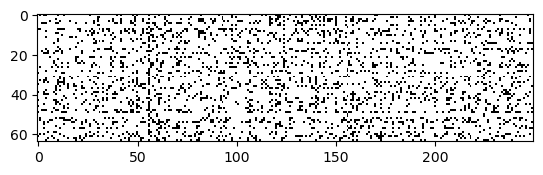

In [583]:
ix = torch.randint(0, X_train.shape[0], (64, ))
emb = C[X_train[ix]]
hidden = emb.view(-1, WORDVEC_DIM * CONTEXT_WINDOW) @ W1 + b1
plt.imshow(hidden < 0, cmap='gray', interpolation='nearest')

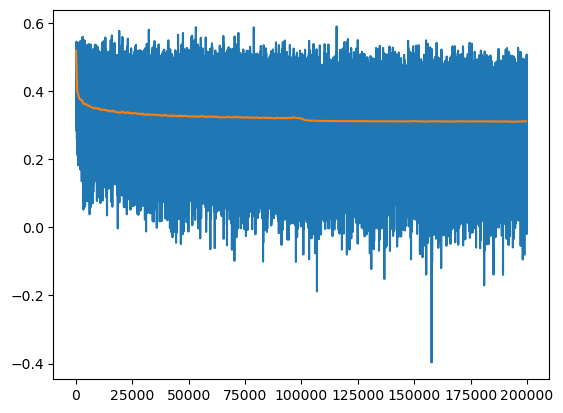

In [584]:
plt.plot(step, losses)
plt.plot(val_steps, val_losses)

In [585]:
emb = C[X_train]
hidden = torch.relu(emb.view(-1, CONTEXT_WINDOW * WORDVEC_DIM) @ W1 + b1)
logits = hidden @ W2 + b2
loss = F.cross_entropy(logits, Y_train)
loss.item()

1.9470930099487305

In [586]:
emb = C[X_val]
hidden = torch.relu(emb.view(-1, CONTEXT_WINDOW * WORDVEC_DIM) @ W1 + b1)
logits = hidden @ W2 + b2
bob = F.cross_entropy(logits, Y_val)
bob


tensor(2.0464, grad_fn=<NllLossBackward0>)

In [587]:
for _ in range(10):
    res = []
    context = [0] * CONTEXT_WINDOW
    while True:
        xenc = C[torch.tensor([context])]
        hidden =torch.relu(xenc.view(1, -1) @ W1 + b1)
        logits = hidden @ W2 + b2
        probs = F.softmax(logits, dim=1)
        token = torch.multinomial(probs, num_samples=1, replacement=True).item()
        context = context[1:] + [token]
        if token == 0:
            break
        res.append(token)
    
    print(''.join([itoc[idx] for idx in res]))
        
        

tobere
yana
aaelynna
colden
yaline
janaa
malayneem
ochayan
colvynn
hildon


# NUMBER TO BEAT ---> 1.17